In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import linear_model

from collections import defaultdict

In [2]:
# load saved data (make sure to download w/ downloadData.py)
event = '2020ncwak'

with open(f"data/{event}.json", 'r') as f:
    json_data = json.load(f)

json_data.keys()
matches = json_data['matches']
oprs = json_data['oprs']
teams = json_data['teams']

In [3]:
# parse into pandas dataframe
def flatten_data_matches(json_data):
    data_dict = defaultdict(list)

    for match in matches:
        match_data = matches[match]
        
        data_dict['match_key'].append(match_data['key'])
        data_dict['match_type'].append(match_data['match_type'])
        data_dict['match_number'].append(match_data['number'])

        for alliance_color in ['blue', 'red']:
            alliance_data = match_data['alliances'][alliance_color]
            for robot_num, robot_key in enumerate(alliance_data['team_keys']):
                data_dict[f"{alliance_color}_{robot_num+1}_key"].append(robot_key)
            data_dict[f"{alliance_color}_keys"].append(alliance_data['team_keys'])
            
            score_breakdown = alliance_data['score_breakdown']
            
            data_dict[f"{alliance_color}_endgame_level"].append(score_breakdown['endgame_level'])
            data_dict[f"{alliance_color}_foul_count"].append(score_breakdown['foul_count'])
            data_dict[f"{alliance_color}_points_scored"].append(score_breakdown['points_scored'])
            data_dict[f"{alliance_color}_max_stage"].append(score_breakdown['max_stage'])
            data_dict[f"{alliance_color}_hang_rp"].append(score_breakdown['rp']['shield_operational'])
            data_dict[f"{alliance_color}_wheel_rp"].append(score_breakdown['rp']['shield_energized'])
            
            for robot_num, init_line_points in enumerate(score_breakdown['init_lines']):
                data_dict[f"{alliance_color}_{robot_num+1}_init_line"].append(init_line_points)
            for robot_num, endgame_points in enumerate(score_breakdown['endgames']):
                data_dict[f"{alliance_color}_{robot_num+1}_endgame"].append(endgame_points)
            
            for cell_placement in ['bottom', 'outer', 'inner']:
                for opmode in ['auto', 'teleop']:
                    data_dict[f"{alliance_color}_cells_{cell_placement}_{opmode}"].append(score_breakdown['cells'][cell_placement][opmode])
            

    df = pd.DataFrame(data=data_dict)
    return df

all_match_data = flatten_data_matches(json_data)
qualification_matches = all_match_data.loc[all_match_data['match_type'] == 'qm']
qualification_matches

,match_key,match_type,match_number,blue_1_key,blue_2_key,blue_3_key,blue_keys,blue_endgame_level,blue_foul_count,blue_points_scored,...,red_3_init_line,red_1_endgame,red_2_endgame,red_3_endgame,red_cells_bottom_auto,red_cells_bottom_teleop,red_cells_outer_auto,red_cells_outer_teleop,red_cells_inner_auto,red_cells_inner_teleop
11,2020ncwak_qm1,qm,1,frc435,frc6565,frc5511,"[frc435, frc6565, frc5511]",True,1,81,...,5,0,5,5,0,0,0,0,0,0
12,2020ncwak_qm10,qm,10,frc5919,frc7265,frc4291,"[frc5919, frc7265, frc4291]",True,0,10,...,5,0,0,25,0,0,3,0,0,0
13,2020ncwak_qm11,qm,11,frc435,frc6240,frc6502,"[frc435, frc6240, frc6502]",False,0,73,...,5,5,5,5,0,9,0,0,0,0
14,2020ncwak_qm12,qm,12,frc3459,frc4828,frc5190,"[frc3459, frc4828, frc5190]",False,0,107,...,5,5,5,0,0,0,0,0,0,0
15,2020ncwak_qm13,qm,13,frc7890,frc5518,frc5511,"[frc7890, frc5518, frc5511]",True,0,92,...,5,5,5,0,0,4,0,1,0,0
16,2020ncwak_qm14,qm,14,frc5607,frc5160,frc2642,"[frc5607, frc5160, frc2642]",True,0,27,...,0,5,0,5,0,0,2,1,1,1
17,2020ncwak_qm15,qm,15,frc6500,frc3459,frc6496,"[frc6500, frc3459, frc6496]",False,1,59,...,5,5,5,5,0,0,3,3,0,0
18,2020ncwak_qm16,qm,16,frc2059,frc5919,frc5762,"[frc2059, frc5919, frc5762]",False,4,37,...,5,5,5,5,0,5,1,5,2,0
19,2020ncwak_qm17,qm,17,frc8090,frc7890,frc3229,"[frc8090, frc7890, frc3229]",True,0,50,...,5,5,5,5,0,0,0,6,0,0
20,2020ncwak_qm18,qm,18,frc7671,frc5160,frc7463,"[frc7671, frc5160, frc7463]",False,0,54,...,0,5,5,0,1,1,0,0,0,0


In [4]:
# get team scores into a dataframe
team_scores = []

def get_match_team_data_breakdown(match_data, alliance_color):
    return [
        match_data[f'{alliance_color}_points_scored'],
        match_data[f'{alliance_color}_cells_bottom_auto'],
        match_data[f'{alliance_color}_cells_bottom_teleop'],
        match_data[f'{alliance_color}_cells_outer_auto'],
        match_data[f'{alliance_color}_cells_outer_teleop'],
        match_data[f'{alliance_color}_cells_inner_auto'],
        match_data[f'{alliance_color}_cells_inner_teleop']
    ] 

for _, match in qualification_matches.iterrows():
    for team in match['blue_keys']:
        team_scores.append([team] + get_match_team_data_breakdown(match, 'blue'))
    for team in match['red_keys']:
        team_scores.append([team] + get_match_team_data_breakdown(match, 'red'))
team_scores = pd.DataFrame(team_scores, columns=['team_key', 'team_score', 'bottom_auto_cells', 'bottom_teleop_cells', 'outer_auto_cells', 'outer_teleop_cells', 'inner_auto_cells', 'inner_teleop_cells'])
team_scores = team_scores.sort_values(by=['team_key'])
team_scores

,team_key,team_score,bottom_auto_cells,bottom_teleop_cells,outer_auto_cells,outer_teleop_cells,inner_auto_cells,inner_teleop_cells
206,frc2059,45,0,0,2,6,2,1
293,frc2059,121,0,0,3,9,0,2
100,frc2059,33,0,4,1,0,0,0
33,frc2059,34,0,0,2,1,1,1
42,frc2059,37,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...
216,frc8090,89,2,4,2,6,1,0
285,frc8090,69,3,3,0,0,0,0
322,frc8090,35,3,4,2,1,0,0
244,frc8090,68,3,0,2,3,0,1


In [6]:
# get team data (like opr) into a dataframe
def get_feature(team_key, data, feature_name):
    return data.loc[data['team_key'] == team_key][feature_name]

team_data = []
for team in teams:
    team_data.append([
        team,
        oprs[team],
        np.mean(get_feature(team, team_scores, 'team_score')),
        np.mean(get_feature(team, team_scores, 'bottom_auto_cells')),
        np.mean(get_feature(team, team_scores, 'bottom_teleop_cells')),
        np.mean(get_feature(team, team_scores, 'outer_auto_cells')),
        np.mean(get_feature(team, team_scores, 'outer_teleop_cells')),
        np.mean(get_feature(team, team_scores, 'inner_auto_cells')),
        np.mean(get_feature(team, team_scores, 'inner_teleop_cells')),
    ])
team_data = pd.DataFrame(team_data, columns=['team_key', 'opr', 'mean_score', 'mean_bottom_auto_cells', 'mean_bottom_teleop_cells', 'mean_outer_auto_cells', 'mean_outer_teleop_cells', 'mean_inner_auto_cells', 'mean_inner_teleop_cells'])
team_data.sort_values(by=['mean_score'])

,team_key,opr,mean_score,mean_bottom_auto_cells,mean_bottom_teleop_cells,mean_outer_auto_cells,mean_outer_teleop_cells,mean_inner_auto_cells,mean_inner_teleop_cells
23,frc7265,-1.961211,31.833333,0.000000,0.916667,1.000000,1.750000,0.250000,0.083333
24,frc7463,5.859754,39.833333,0.666667,1.416667,1.333333,2.083333,0.166667,0.250000
13,frc5607,6.231308,45.583333,0.416667,0.666667,0.833333,4.500000,0.500000,0.416667
12,frc5518,16.583076,46.000000,0.333333,1.083333,1.083333,2.666667,0.333333,0.583333
17,frc6240,12.304167,46.500000,0.166667,1.583333,1.083333,2.750000,0.083333,0.583333
14,frc5762,12.175355,48.833333,0.500000,2.583333,0.750000,3.583333,0.166667,0.666667
26,frc7763,18.972538,50.333333,0.000000,3.833333,0.833333,2.583333,0.333333,0.333333
21,frc6565,9.628913,50.500000,0.500000,2.666667,1.000000,2.916667,0.416667,0.250000
7,frc4816,20.392981,52.250000,0.250000,2.333333,0.583333,2.833333,0.750000,0.500000
28,frc8090,7.806520,52.583333,1.500000,3.416667,0.750000,1.416667,0.416667,0.250000


In [121]:
# per component OPR
# thanks to [this](https://blog.thebluealliance.com/2017/10/05/the-math-behind-opr-an-introduction/)
def calculate_oprs(point_objective):
    match_matrix = np.zeros((len(qualification_matches)*2, len(teams)))
    score_matrix = np.zeros((len(qualification_matches)*2, 1))

    for _, match in qualification_matches.iterrows():
        i = match['match_number']-1
        for red_team in match['red_keys']:
            match_matrix[i*2][teams.index(red_team)] = 1
        score_matrix[i*2][0] = match[f'red_{point_objective}']

        for blue_team in match['blue_keys']:
            match_matrix[i*2+1][teams.index(blue_team)] = 1
        score_matrix[i*2+1][0] = match[f'blue_{point_objective}']

    left_matrix = match_matrix.T.dot(match_matrix)
    right_matrix = match_matrix.T.dot(score_matrix)
    opr_matrix = np.linalg.inv(left_matrix).dot(right_matrix)
    return opr_matrix

team_component_opr_data = []
for i, team in enumerate(teams):
    team_component_opr_data.append([
        team,
        calculate_oprs('points_scored')[i][0],
        calculate_oprs('cells_bottom_auto')[i][0],
        calculate_oprs('cells_bottom_teleop')[i][0],
        calculate_oprs('cells_inner_auto')[i][0],
        calculate_oprs('cells_inner_teleop')[i][0],
        calculate_oprs('cells_outer_auto')[i][0],
        calculate_oprs('cells_outer_teleop')[i][0],
        team_data.loc[team_data['team_key'] == team].iloc[0]['mean_score']
    ])
team_component_opr_data = pd.DataFrame(team_component_opr_data, columns=['team_key', 'points_scored', 'cells_bottom_auto', 'cells_bottom_teleop', 'cells_inner_auto', 'cells_inner_teleop', 'cells_outer_auto', 'cells_outer_teleop', 'mean_score'])
team_component_opr_data

,team_key,points_scored,cells_bottom_auto,cells_bottom_teleop,cells_inner_auto,cells_inner_teleop,cells_outer_auto,cells_outer_teleop,mean_score
0,frc2059,17.894015,-0.179199,-0.394938,0.159099,0.370512,0.378372,1.200113,56.666667
1,frc2642,22.768461,0.067028,-0.382071,-0.011605,0.637432,-0.158856,1.133719,66.583333
2,frc3229,14.960390,0.206528,-0.290296,-0.006245,0.087639,1.621151,2.257098,54.000000
3,frc3459,36.080602,0.104617,-0.281045,0.398681,0.115399,0.964173,1.116617,76.166667
4,frc4291,21.166143,-0.013693,0.666192,0.202066,0.298168,-0.010441,-0.527996,60.916667
5,frc435,28.398827,0.085043,0.636487,-0.294618,0.384415,0.414097,1.725952,67.583333
6,frc4561,33.786561,0.240662,-0.930977,0.271350,0.868120,1.597576,3.039763,70.666667
7,frc4816,15.268651,-0.059782,0.866532,0.607468,-0.002908,-0.450142,-0.072344,52.250000
8,frc4828,30.687604,-0.225168,0.471115,0.078645,-0.202540,1.717093,1.257233,73.666667
9,frc5160,42.045429,2.166404,9.298249,-0.157610,-0.010312,0.061696,0.340771,85.000000


Text(0, 0.5, 'Points scored (excluding penalties)')

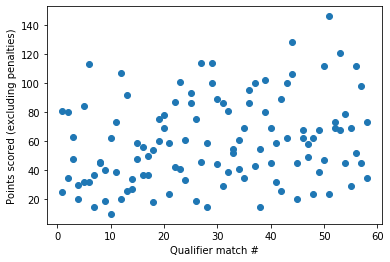

In [7]:
# graph score over time
plt.scatter(
    pd.concat([qualification_matches['match_number'], qualification_matches['match_number']], axis=1),
    pd.concat([qualification_matches['blue_points_scored'], qualification_matches['red_points_scored']], axis=1)
)
plt.xlabel('Qualifier match #')
plt.ylabel('Points scored (excluding penalties)')

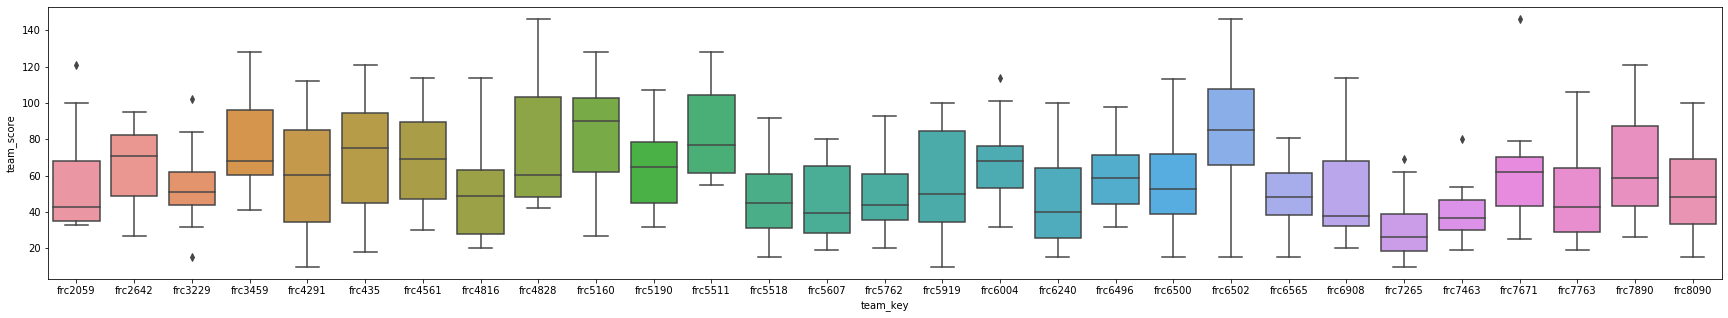

In [8]:
# boxplot team scores
plt.figure(figsize=(30,5))
sns.boxplot(x="team_key", y="team_score", data=team_scores)

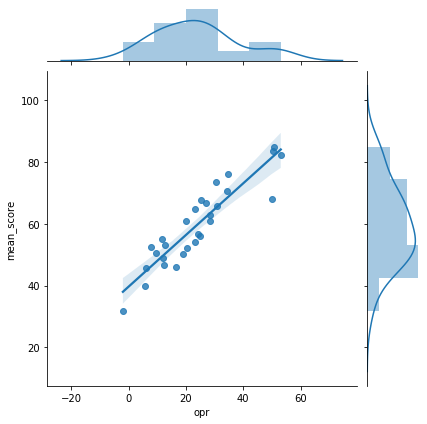

In [9]:
# joint plot opr/team scores
sns.jointplot('opr', 'mean_score', data=team_data, kind='reg')

In [124]:
# alright, stats time
# let's see what variables have the biggest effect on team score
def perform_regression(data, features, target):
    reg = linear_model.LinearRegression()
    x = []
    y = []

    for _, data_row in data.iterrows():
        x.append([data_row[i] for i in features])
        y.append(data_row[target])
    reg.fit(x, y)

    return reg, reg.score(x, y)

features = ['mean_bottom_auto_cells', 'mean_bottom_teleop_cells', 'mean_outer_auto_cells', 'mean_outer_teleop_cells', 'mean_inner_auto_cells', 'mean_inner_teleop_cells']
reg, r2 = perform_regression(team_data, features, 'mean_score')

print(f"R^2: {r2}")

reg_coef = {f: reg.coef_[i] for i, f in enumerate(features)}
reg_coef

R^2: 0.7806717261798815


{'mean_bottom_auto_cells': 2.0200854413369282,
 'mean_bottom_teleop_cells': 3.99945045596636,
 'mean_outer_auto_cells': 9.090817916153647,
 'mean_outer_teleop_cells': 0.9249251515693213,
 'mean_inner_auto_cells': 10.39239017468633,
 'mean_inner_teleop_cells': 5.906931360081379}

Looking at the above data it looks like the things that have the biggest impact on mean score are, in order:
- mean_outer_teleop_cells
- mean_bottom_auto_cells
- mean_bottom_teleop_cells
- mean_inner_teleop_cells
- mean_outer_auto_cells
- mean_inner_auto_cells

A bigger coefficient means that it has to be weighted higher to have as much of an impact on the model, so things with a lower coefficient are more important to the results

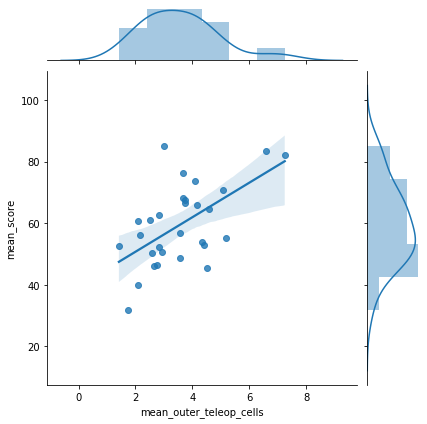

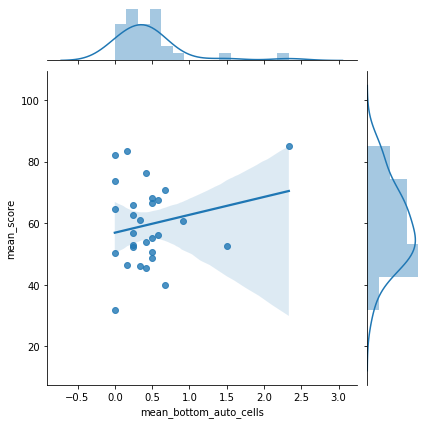

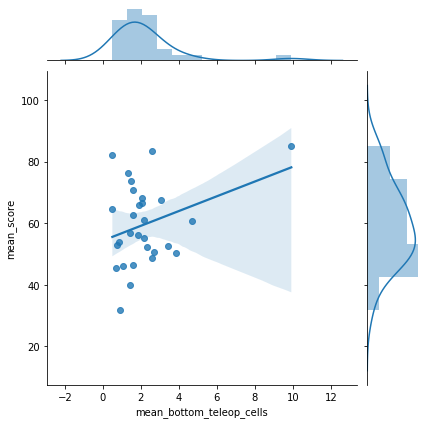

In [37]:
sns.jointplot('mean_outer_teleop_cells', 'mean_score', data=team_data, kind='reg')
sns.jointplot('mean_bottom_auto_cells', 'mean_score', data=team_data, kind='reg')
sns.jointplot('mean_bottom_teleop_cells', 'mean_score', data=team_data, kind='reg')

After looking at the above plots, our team might be severely affecting the fit

In [128]:
# perform the same analysis with component OPR
features = ['cells_bottom_auto', 'cells_bottom_teleop', 'cells_inner_auto', 'cells_inner_teleop', 'cells_outer_auto', 'cells_outer_teleop']
reg, r2 = perform_regression(team_component_opr_data, features, 'mean_score')

print(f"R^2: {r2}")

reg_coef = {f: reg.coef_[i] for i, f in enumerate(features)}
reg_coef

R^2: 0.6871327816153491


{'cells_bottom_auto': 0.07562135123018306,
 'cells_bottom_teleop': 3.671021955228203,
 'cells_inner_auto': 9.03792149294612,
 'cells_inner_teleop': 8.719657418572654,
 'cells_outer_auto': 7.759928971669952,
 'cells_outer_teleop': 0.618142574952433}

This is effectively the same regression analysis as before, but looking at component OPRs this time.
The most important things to look at are:
- cells_bottom_auto
- cells_outer_teleop
- cells_bottom_teleop
- cells_outer_auto
- cells_inner_teleop
- cells_inner_auto

Again, it's very likely that this data/the fit is being drastically affected by our teams impact (looking at cells_bottom_auto specifically...)

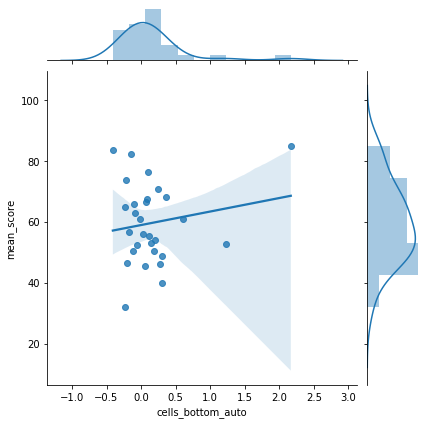

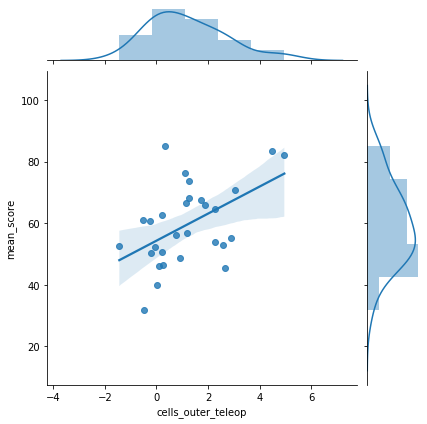

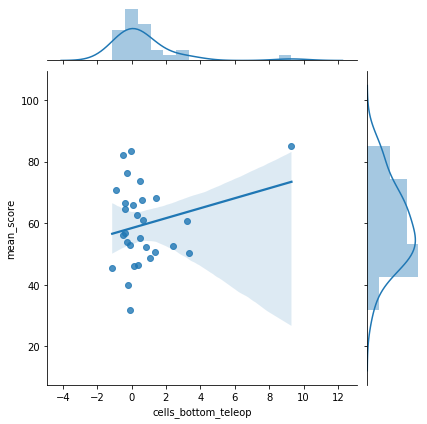

In [126]:
sns.jointplot('cells_bottom_auto', 'mean_score', data=team_component_opr_data, kind='reg')
sns.jointplot('cells_outer_teleop', 'mean_score', data=team_component_opr_data, kind='reg')
sns.jointplot('cells_bottom_teleop', 'mean_score', data=team_component_opr_data, kind='reg')

Since our team keeps appearing as a potential outlier, we should really make an effort to prove that the claim of that is the case.